In [1]:
import sys

sys.path.insert(0, '..')

import torch
import numpy as np
from torchvision import transforms

from pyhandle.dataset.dataloader import TorchLoader
from pyhandle.net.intermediate import IntermediateNetwork
from net.ssd import SSD300, MultiBoxLoss
from utils.obj_utils import cxcy_to_xy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

In [2]:
coco_root = '/home/sixigma/workplace/meow/coco_data/'

In [3]:
import torchvision

coco = torchvision.datasets.coco.CocoDetection(root=coco_root + 'train/train2017/', annFile=coco_root + 'annotations/instances_train2017.json')

loading annotations into memory...
Done (t=9.40s)
creating index...
index created!


In [4]:
resnet = IntermediateNetwork('resnet50', [5, 6])
ssd_net = SSD300(resnet, 80)

In [5]:
priors = cxcy_to_xy(ssd_net.priors_cxcy).to(device)
multibox = MultiBoxLoss(priors.to(device))
boxes = []
labels = []
width, height = coco[1][0].size
for obj in range(len(coco[1][1])):
    # coco bounding box format [top left x position, top left y position, width, height]
    box = coco[1][1][obj]['bbox']
    box = [box[0] / width, box[1] / height, box[0] / width + box[2] / width, box[1] / height + box[3] / height]
    boxes.append(box)
    labels.append(coco[1][1][obj]['category_id'])
t_boxes = torch.FloatTensor([boxes]).to(device)
t_labels = torch.FloatTensor([labels]).to(device)

/home/sixigma/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [6]:
image = np.array(transforms.Resize((300, 300))((coco[0][0])))
t_image = torch.from_numpy(image).permute(2, 0, 1).float().to(device)
locs, cls = ssd_net(transforms.Normalize(0, 255)(t_image).expand([1, -1, -1, -1]))
locs = locs.to(device)
cls = cls.to(device)

In [7]:
loss = multibox(locs, cls, t_boxes, t_labels)
loss

tensor(28.9723, device='cuda:0', grad_fn=<AddBackward0>)

In [8]:
locs.shape, t_boxes.shape, priors.shape

(torch.Size([1, 8732, 4]), torch.Size([1, 2, 4]), torch.Size([8732, 4]))

In [9]:
locs[:, :2, :], priors[:2, :], t_boxes[:, :8, :]

(tensor([[[-0.7521, -2.1579, -0.4257, -0.2361],
          [ 0.2105, -0.2304,  0.0928, -1.1341]]], device='cuda:0',
        grad_fn=<SliceBackward>),
 tensor([[-0.0368, -0.0368,  0.0632,  0.0632],
         [-0.0576, -0.0576,  0.0839,  0.0839]], device='cuda:0'),
 tensor([[[0.6024, 0.1409, 0.9383, 0.8385],
          [0.0828, 0.8368, 0.2891, 0.9664]]], device='cuda:0'))

In [10]:
t_labels, cls

(tensor([[25., 25.]], device='cuda:0'),
 tensor([[[-1.4942e-01,  4.6364e-01, -6.9559e-01,  ...,  9.1386e-02,
            4.7071e-01,  4.1013e-02],
          [-8.7487e-02, -2.8849e-01,  6.9809e-01,  ..., -1.4811e-01,
            6.3747e-01, -1.4893e-01],
          [ 6.9941e-01,  1.9839e-01, -3.3932e-01,  ..., -6.7081e-01,
            7.9789e-01, -1.8384e-01],
          ...,
          [-1.3621e-03,  2.1182e-03,  1.7862e-03,  ...,  6.3697e-03,
           -1.1739e-03, -2.1077e-03],
          [-4.6454e-03, -5.1110e-04,  2.0609e-03,  ..., -1.5463e-04,
           -1.4598e-03,  1.6893e-03],
          [ 8.1374e-04,  2.1444e-03,  9.8222e-04,  ...,  2.7095e-04,
            2.5932e-03, -1.4396e-03]]], device='cuda:0', grad_fn=<CatBackward>))

In [11]:
# Get intersection bounding box left_top and right_down coordinate
lower_bounds = torch.max(t_boxes[0, :, :2].unsqueeze(1), priors[:, :2].unsqueeze(0))
upper_bounds = torch.min(t_boxes[0, :, 2:].unsqueeze(1), priors[:, 2:].unsqueeze(0))

In [12]:
# Get intersection bounding box width and height
intersection_dims = torch.clamp(upper_bounds - lower_bounds, min=0)

# Get volumn of intersection bounding box
intersection_area = intersection_dims[:, :, 0] * intersection_dims[:, :, 1]

# 
areas_set_1 = (t_boxes[0, :, 2] - t_boxes[0, :, 0]) * (t_boxes[0, :, 3] - t_boxes[0, :, 1])
areas_set_2 = (priors[:, 2] - priors[:, 0]) * (priors[:, 3] - priors[:, 1])

union = areas_set_1.unsqueeze(1) + areas_set_2.unsqueeze(0) - intersection_area
iou = intersection_area / union  # shape (n_obj, 8732)

In [13]:
overlap_for_every_obj_iou, overlap_for_every_obj_idx = iou.max(dim=1) # shape (n_obj)

<Figure size 432x288 with 0 Axes>

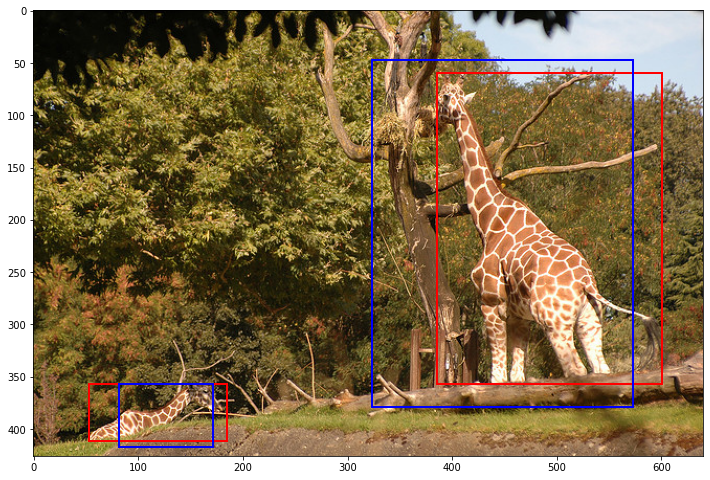

In [14]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

plt.figure()
fig, ax = plt.subplots(1, figsize=(12,9))
ax.imshow(coco[1][0])

# Get bounding-box colors
cmap = plt.get_cmap('tab20b')
colors = [cmap(i) for i in np.linspace(0, 1, 20)]

# groundtruth box
for obj in boxes:
    x = obj[0] * width
    y = obj[1] * height
    box_w = (obj[2] - obj[0]) * width
    box_h = (obj[3] - obj[1]) * height
    bbox = patches.Rectangle((x, y), box_w, box_h,
             linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(bbox)
    
for prior in priors[overlap_for_every_obj_idx]:
    x = prior[0] * width
    y = prior[1] * height
    box_w = (prior[2] - prior[0]) * width
    box_h = (prior[3] - prior[1]) * height
    bbox = patches.Rectangle((x, y), box_w, box_h,
             linewidth=2, edgecolor='b', facecolor='none')
    ax.add_patch(bbox)

plt.show()